In [78]:
import numpy as np
import numpy.random as nrd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.linear_model import Lasso

from warnings import warn

# Exercise 17.8

(a) Write a program to fit the lasso using the coordinate descent procedure (17.26). Compare its results to those from the lars program or some other convex optimizer, to check that it is working correctly.

(b) Using the program from (a), write code to implement the graphical lasso (Algorithm 17.2). Apply it to the flow cytometry data from the book website. Vary the regularization parameter and examine the resulting networks

# Solution (a)

Let's implement the pathway coordinate descent procedure,

In [41]:
class CoordinateDescentAlgorithm():
    
    def __init__(self,random_state=0):
        self.rng = nrd.default_rng(seed=random_state)
    
    # randomly initialize the beta coefficient
    def initialize_coefficients(self,N):
        return self.rng.random(N)
    
    # soft treshold function
    def soft_treshold(self,x,t):
        return np.sign(x) * max((abs(x)-t,0))
    
    # coordinate descent algorithm to estimate beta for solving the modified lasso problem
    def get_coefficients(self,V,s,lamb,max_iterations=100):
        
        _,N = V.shape
        
        beta = self.initialize_coefficients(N)
        
        converged = False
        
        for i in range(max_iterations):
            
            prev_beta = beta.copy()
            
            for j in range(N):
                
                beta_reduced = np.delete(beta,j)
                V_reduced = np.delete(V.T[j],j)
                
                # Update beta values 
                beta[j] = self.soft_treshold(s[j] - beta_reduced @ V_reduced,lamb)/V[j,j]
                
            if np.allclose(prev_beta,beta):
                converged = True
                break
                
        if not converged:
            warn("The method has not converged, try increasing max_iterations.")
            
        return beta

Let's check that it works by applying Lasso from sklearn to random matrices,

In [46]:
N = 100
p = 10

lamb = 5e-2

# random imput and output samples, for the lasso
Z = nrd.normal(size=(N,p))
y = nrd.normal(size=N)

# the corresponding V and s matrices for the coordinate descent algorithm
V = Z.T @ Z / N
s = Z.T @ y / N

# Lasso with sklearn
model = Lasso(alpha=lamb, fit_intercept=False)
model.fit(Z,y)

print('beta (lasso) = {}'.format(model.coef_))

# Coordinate descent algorithm
model2 = CoordinateDescentAlgorithm()
coef2 = model2.get_coefficients(V,s,lamb)
print('beta (CDA) = {}'.format(coef2))

beta (lasso) = [ 0.          0.          0.1538758   0.00321192 -0.         -0.
  0.16203856  0.         -0.0046855  -0.08837595]
beta (CDA) = [ 0.          0.          0.15387598  0.00321188 -0.         -0.
  0.16203851  0.         -0.00468547 -0.08837597]


They provide the same beta vector (for different lambdas).

# Solution (b)

Now we need to implement the graphical lasso,

In [81]:
class GraphicalLasso():
    
    def __init__(self,optimizer,vertices,scale=1):
        
        # The Coordinate Descent Algorithm
        self.optimizer = optimizer
        
        self.vertices = vertices
        
        # Scale for the sampled covariance matrix
        self.scale = scale
    
    def features_partitioning(self,j):
        
        # remove j-th column + row from W
        W_reduced = np.delete(self.W,j,axis=0)
        W_reduced = np.delete(W_reduced,j,axis=1)
        
        # select j-th row from S (remove j-th column)
        s_vector = np.delete(self.S[j],j)
        
        return W_reduced, s_vector
    
    # Compute the inverse of the covariance matrix, (has info on conditional independence)
    def compute_omega(self,coefficients):
        
        self.omega = np.zeros((self.p,self.p))
        
        for j in range(self.p):
            
            # select rows/columns to be updated
            index_update = np.arange(self.p,dtype=int) != j
            
            # get the relevant coefficients
            beta = coefficients[j]
            
            # Update the omega matrix
            self.omega[j,j] = 1/(self.W[j,j] - self.W[j,index_update] @ beta)
            self.omega[j,index_update] = -self.omega[j,j] * beta
            self.omega[index_update,j] = -self.omega[j,j] * beta
    
    def fit(self,X,lamb,max_iterations=100):
        
        _,self.p = X.shape
        
        converged = False
        
        beta = {} # Store coefficient list for last step of algorithm
        
        # Sampled covariance matrix
        self.S = np.cov(X.T)/self.scale
        
        # Initialization for W, regularized covariance matrix
        self.W = self.S + lamb * np.identity(self.p)
        
        for _ in range(max_iterations):
            
            previous_W = self.W.copy()
        
            for j in range(self.p):
                
                # Partitioning W and S
                W_reduced, s_vector = self.features_partitioning(j)
                
                # Estimate beta parameter
                beta[j] = self.optimizer.get_coefficients(W_reduced,s_vector,lamb)
                
                # Update W matrix
                index_update = np.arange(self.p,dtype=int) != j
                
                self.W[j,index_update] = W_reduced @ beta[j]
                self.W[index_update,j] = W_reduced @ beta[j]
                
            if np.allclose(previous_W,self.W):
                converged = True
                break
                 
        if not converged:
            warn("Method has not converged. Try increasing the max_iteration parameter.")
        
        # Compute inverse of covariance matrix
        self.compute_omega(beta)
        
    def show_graph(self,size=300):
        
        # Identify edges of the graph (where entries of omega are non-zero)
        rows, cols = np.where(self.omega != 0)
        edges = zip(rows.tolist(), cols.tolist())
        
        # Create undirected graph from edges
        graph = nx.Graph()
        graph.add_edges_from(edges)
        
        # Specify the name of the labels
        vertices_label = dict(enumerate(self.vertices))
        
        # Drow the graph
        nx.draw(graph,
                pos=nx.circular_layout(graph), # Use a circular layout for the graph
                node_size=size,
                labels=vertices_label,
                with_labels=True
               )
        
        plt.show()        

## Main dataset (protein)

Let's apply the graphical lasso to the following dataset,

In [52]:
vertices = ["praf","pmek","plcg","PIP2","PIP3","p44/42","pakts473","PKA","PKC","P38","pjnk"]
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/sachs.data'
df = pd.read_csv(url_link,sep=' ',header=None,names=vertices)

df.tail()

,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
7461,-74.97193,-132.981,-22.05364,-123.22070,-4.334962,-14.931190,-42.96721,518.2414,-29.34166,-132.4645,-72.2675
7462,-100.77190,-140.771,-37.05364,-129.02070,-12.134960,22.068810,-13.86721,296.2414,-29.34166,-125.1945,-72.2675
7463,-95.97193,-140.891,-36.05364,-130.92070,-16.834960,-23.551190,-59.26721,104.2414,-29.34166,-133.2645,-71.2675
7464,-89.47193,-138.281,-49.12364,-130.42070,-11.934960,5.568807,-39.76721,187.2414,14.15834,1246.9850,-70.8275
7465,-93.57193,-144.371,-47.55364,21.87926,-4.134962,-20.021190,-67.46721,264.2414,-29.34166,-134.0145,-71.6175


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466 entries, 0 to 7465
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   praf      7466 non-null   float64
 1   pmek      7466 non-null   float64
 2   plcg      7466 non-null   float64
 3   PIP2      7466 non-null   float64
 4   PIP3      7466 non-null   float64
 5   p44/42    7466 non-null   float64
 6   pakts473  7466 non-null   float64
 7   PKA       7466 non-null   float64
 8   PKC       7466 non-null   float64
 9   P38       7466 non-null   float64
 10  pjnk      7466 non-null   float64
dtypes: float64(11)
memory usage: 641.7 KB


In [54]:
X = df.to_numpy()

Let's apply the graphical lasso to the data,

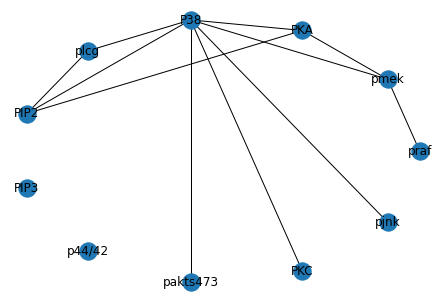

In [86]:
optimizer = CoordinateDescentAlgorithm()
model = GraphicalLasso(optimizer,vertices,scale=1000)

lamb = 27

model.fit(X,lamb)
model.show_graph()

We obtain the same graph as in the main text.